/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 2  3  4  5  7  8 10 11 12 23] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
<ipython-input-20-8909088ca509>:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_scores, x='Score', y='Feature', palette='viridis')


Top Selected Features:
             Feature         Score
1         timestamp  49621.712439
4           numeric  44182.544012
5           special  41132.623820
3  subdomain_length  39294.185754
6            labels  39249.856302
2        FQDN_count  36518.275865
9         subdomain  27030.990640
7      longest_word  15582.702139
8               sld  15208.270799
0          ttl_mean  11212.696035


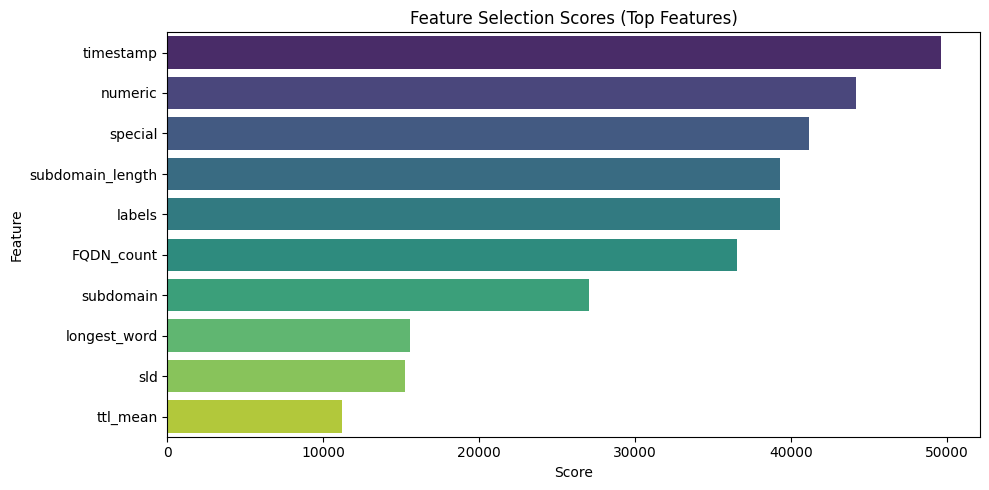

Train Accuracy of original model: 0.9515936018416172
Test accuracy of original model: 0.9493203741596025
Train Accuracy of adversarial trained model: 0.9757922334176798
Test accuracy of adversarial model: 0.9493203741596025

Classification Report of test data using original model:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96     16557
           1       0.89      1.00      0.94     10811

    accuracy                           0.95     27368
   macro avg       0.94      0.96      0.95     27368
weighted avg       0.95      0.95      0.95     27368


Classification Report of test data using adversarial model:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96     16557
           1       0.89      1.00      0.94     10811

    accuracy                           0.95     27368
   macro avg       0.94      0.96      0.95     27368
weighted avg       0.95      0.95      0.95     27368



<ipython-input-20-8909088ca509>:172: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='Metric', y='Score', palette='muted')


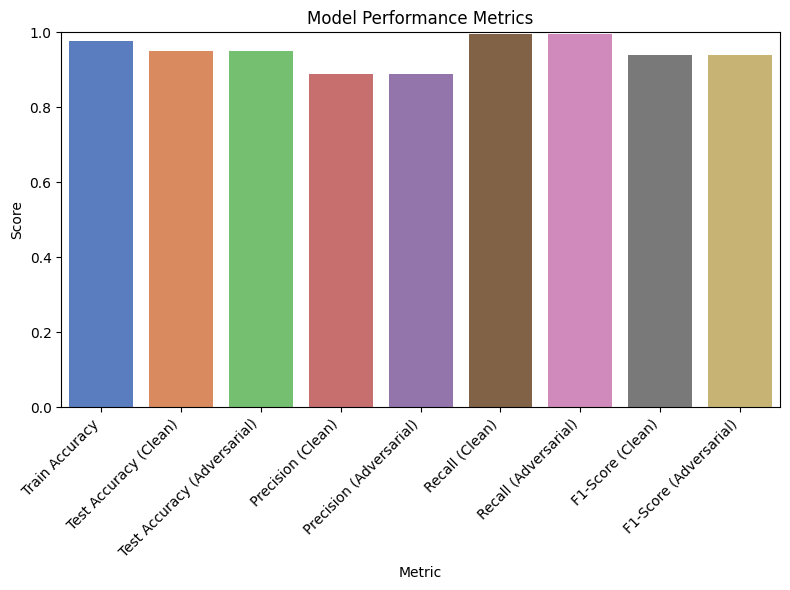

Number of original training samples: 109469
Number of adversarial training samples: 109469
Number of test samples: 27368

Confusion Matrix on Original Model :


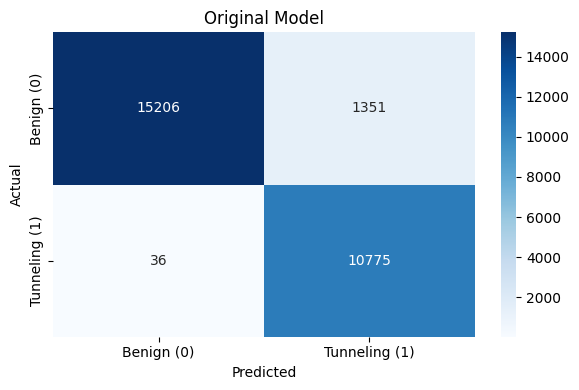


Confusion Matrix on Adversarial Trained Model:


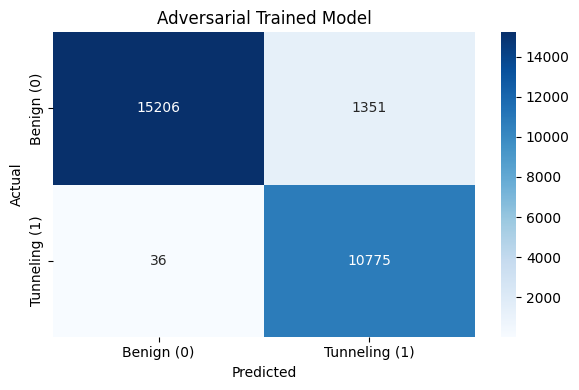

<ipython-input-20-8909088ca509>:203: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Train Accuracy', 'Test Accuracy (Clean)', 'Test Accuracy (Adversarial)'],


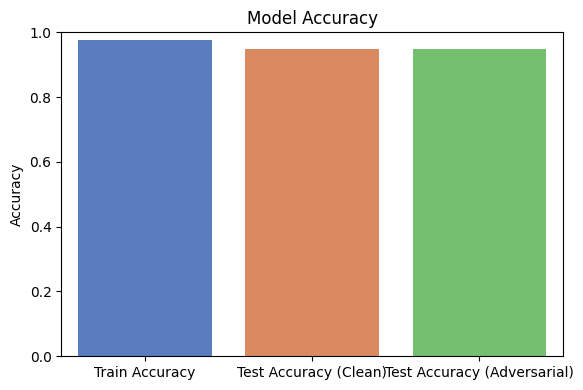

In [20]:
import zipfile
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

tunnels_data_path = '/content/Attacks.zip'
regular_data_path = '/content/Benign.zip'


def load_csv_from_zip(zip_path):
    csv_files = []
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall('/content/extracted_files')
            for file_name in zip_ref.namelist():
                if file_name.endswith('.csv'):
                    csv_files.append(os.path.join('/content/extracted_files', file_name))
    except Exception as e:
        print(f"Error extracting files from {zip_path}: {e}")
    data_frames = {}
    for file in csv_files:
        try:
            df = pd.read_csv(file)
            data_frames[file] = df
        except Exception as e:
            print(f"Error loading {file}: {e}")
    return data_frames

regular_data_frames = load_csv_from_zip(regular_data_path)
tunnels_data_frames = load_csv_from_zip(tunnels_data_path)

regular_data = pd.concat(regular_data_frames.values(), axis=0).reset_index(drop=True)
tunnels_data = pd.concat(tunnels_data_frames.values(), axis=0).reset_index(drop=True)

regular_data['label'] = 0
tunnels_data['label'] = 1

data = pd.concat([regular_data, tunnels_data], axis=0).reset_index(drop=True)
data = data.sample(frac=1).reset_index(drop=True)

if data.empty:
    print("The combined dataset is empty. Exiting script.")
else:

    X = data.drop(columns=['label'])
    y = data['label']

    non_numeric_cols = X.select_dtypes(include=['object']).columns
    if len(non_numeric_cols) > 0:
        label_encoders = {}
        for col in non_numeric_cols:
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col])
            label_encoders[col] = le

    imputer = SimpleImputer(strategy='mean')
    X_imputed = imputer.fit_transform(X)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_imputed)

    k = 10
    selector = SelectKBest(score_func=f_classif, k=k)
    X_selected = selector.fit_transform(X_scaled, y)

    selected_features = X.columns[selector.get_support()]
    feature_scores = pd.DataFrame({
        'Feature': selected_features,
        'Score': selector.scores_[selector.get_support()]
    }).sort_values(by='Score', ascending=False)
    print("Top Selected Features:\n", feature_scores)

    plt.figure(figsize=(10, 5))
    sns.barplot(data=feature_scores, x='Score', y='Feature', palette='viridis')
    plt.title("Feature Selection Scores (Top Features)")
    plt.xlabel("Score")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

    def generate_adversarial_examples(model, X, y, epsilon=0.01, max_attempts=10):
        adversarial_X = X.copy()
        min_values = X.min(axis=0) if isinstance(X, pd.DataFrame) else X.min(axis=0)
        max_values = X.max(axis=0) if isinstance(X, pd.DataFrame) else X.max(axis=0)
        for i in range(X.shape[0]):
            original_sample = X.iloc[i].values if isinstance(X, pd.DataFrame) else X[i]
            label = y.iloc[i]

            perturbation = epsilon * np.random.uniform(-1, 1, size=X.shape[1])
            perturbed_sample = original_sample + perturbation

            perturbed_sample = np.clip(perturbed_sample, min_values, max_values)

            if isinstance(X, pd.DataFrame):
                adversarial_X.iloc[i] = perturbed_sample
            else:
                adversarial_X[i] = perturbed_sample

        return adversarial_X

    X_train_adv = generate_adversarial_examples(model, X_train, y_train)
    X_combined = np.vstack((X_train, X_train_adv))
    y_combined = np.hstack((y_train, y_train))

    model_adversarial = RandomForestClassifier(random_state=42)
    model_adversarial.fit(X_combined, y_combined)

    y_pred_clean = model.predict(X_test)
    train_accuracy = accuracy_score(y_train, model.predict(X_train))
    print("Train Accuracy of original model:", train_accuracy)
    test_accuracy_clean = accuracy_score(y_test, y_pred_clean)
    print("Test accuracy of original model:", test_accuracy_clean)

    y_pred_adv = model_adversarial.predict(X_test)
    train_accuracy = accuracy_score(y_combined, model_adversarial.predict(X_combined))
    print("Train Accuracy of adversarial trained model:", train_accuracy)
    test_accuracy_adv = accuracy_score(y_test, y_pred_adv)
    print("Test accuracy of adversarial model:", test_accuracy_adv)

    print("\nClassification Report of test data using original model:")
    print(classification_report(y_test, y_pred_clean))
    print("\nClassification Report of test data using adversarial model:")
    print(classification_report(y_test, y_pred_adv))

    precision_clean = precision_score(y_test, y_pred_clean)
    recall_clean = recall_score(y_test, y_pred_clean)
    f1_clean = f1_score(y_test, y_pred_clean)

    precision_adv = precision_score(y_test, y_pred_adv)
    recall_adv = recall_score(y_test, y_pred_adv)
    f1_adv = f1_score(y_test, y_pred_adv)

    metrics_df = pd.DataFrame({
        'Metric': ['Train Accuracy', 'Test Accuracy (Clean)', 'Test Accuracy (Adversarial)',
                   'Precision (Clean)', 'Precision (Adversarial)',
                   'Recall (Clean)', 'Recall (Adversarial)',
                   'F1-Score (Clean)', 'F1-Score (Adversarial)'],
        'Score': [train_accuracy, test_accuracy_clean, test_accuracy_adv,
                  precision_clean, precision_adv,
                  recall_clean, recall_adv,
                  f1_clean, f1_adv]
    })

    plt.figure(figsize=(8, 6))
    sns.barplot(data=metrics_df, x='Metric', y='Score', palette='muted')
    plt.ylim(0, 1)
    plt.title("Model Performance Metrics")
    plt.ylabel("Score")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    def plot_confusion_matrix(cm, class_names, title):
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(title)
        plt.tight_layout()
        plt.show()

    cm_clean = confusion_matrix(y_test, y_pred_clean)
    cm_adv = confusion_matrix(y_test, y_pred_adv)
    print(f"Number of original training samples: {X_train.shape[0]}")
    print(f"Number of adversarial training samples: {X_train_adv.shape[0]}")
    print(f"Number of test samples: {X_test.shape[0]}")

    print("\nConfusion Matrix on Original Model :")
    plot_confusion_matrix(cm_clean, class_names=['Benign (0)', 'Tunneling (1)'], title="Original Model")


    print("\nConfusion Matrix on Adversarial Trained Model:")
    plot_confusion_matrix(cm_adv, class_names=['Benign (0)', 'Tunneling (1)'], title="Adversarial Trained Model")

    plt.figure(figsize=(6, 4))
    sns.barplot(x=['Train Accuracy', 'Test Accuracy (Clean)', 'Test Accuracy (Adversarial)'],
                y=[train_accuracy, test_accuracy_clean, test_accuracy_adv], palette='muted')
    plt.ylim(0, 1)
    plt.title("Model Accuracy")
    plt.ylabel("Accuracy")
    plt.tight_layout()
    plt.show()
